# Part 6 - Predicting Review Classifications

## Tasks
For this part of the project, you will using machine learning and deep NLP to classify the reviews.
### Repo Prep


- Create a `"Models/"` folder in your project repository, with the following sub-folders: 
    - `"Models/ml/"`. You will save your sklearn model pipelines here for later use in deployment.
    - `"Models/nn/"`. You will save your tensorflow models here for later use in deployment.
- Add new subfolders to your "Data-NLP/"" folder.
    - Specifically, create:
        - `"Data-NLP/ml/"` folder. We will save your training and test data (X_train,y_train) for later use in deployment.
        - `"Data-NLP/nn/"` folder.  We will save your training and test Tensorflow datasets for later use in deployment.
     

    
- Create a new notebook for Part 6 - Review Classification for this part of the project. 

### Load the Data

- Load the joblib containing the dataframe from Part 5 of the project.
- Use the original review column as X and the classiifcation target (High/Low Rating Reviews) as y.

___

## Machine Learning
For this project, you will use modeling pipelines with the text vectorizer and model in the same pipeline. This will make it very easy to use save and load the models to use in a deployed application.


### Create a Text Vectorizer
- Select an sklearn vectorizer to for your task.
    - Remember to consider your preprocessing choices like using stopwords, using ngrams, etc.

### Build a Machine Learning Model

- Build an sklearn modeling pipeline with a text vectorizer and a classification model.
    - Suggested Models: MultinomialNB, LogisticRegression, RandomForestClassifier 

- Fit and evaluate the model using the machine learning classification models from sklearn.
    - In a Markdown cell, document your observations from your results. (e.g. how good is the model overall? Is it particularly good/bad at predicting one class?)


### GridSearch Text Vectorization 
Attempt to improve on yourm model by tuning the text preprocessing steps. 

- Construct a grid of parameters for the text vectorization step. Consider trying:
    - CountVectorizer/TfidfVectorizer
    - stopwords
    - ngram_range
    - min_df/max_df

- Fit and evaluate the gridsearch results:
    - What were the best parameters?
    - How does the best estimator perform when evaluated on the training and test data?
 

### Save the Best Model and Train/Test Data  as Joblibs

- Save your overall best model pipeline as the only variable in a .joblib file in your new Models/ folder. (e.g. "Models/ml/best-clf-logreg.joblib")

- Save a list containing `[X_train, y_train]` as `"Data-NLP/ml/train-data.joblib"`
- Save a list containing `[X_test,y_test]`  as `"Data-NLP/ml/test-data.joblib"`


____

## Deep NLP (RNNs)
For this part of the project, you will use a Keras TextVectorization layer as part of your RNN model. This serves the same purpose as using the sklearn pipeline: it bundles text preparation into the model itself, making it deployment-ready.

 
###  Create train/test/val datasets
- Convert the target categories to integers (e.g. Using sklearn's LabelEncoder) 
- Create a tensorflow dataset using the X and  (integer version) of y.
- Split the dataset into a training, test, and validation datasets.

### Create a Keras Text Vectorization layer
- Create a keras text vectorization layer to use in an RNN (sequence) model.
- Fit/Adapt the text vectorization layer on the training texts.
- Save the vocabulary size from layer to use in your models' Embedding layer.


### Build an RNN with the TextVectorization Layer
- Build and fit at least 1 sequence model (LSTM, GRU, Bidirectional, etc)
- Evalaute the model on the training and trest data.
    - In a Markdown cell, document your observations from your results. (e.g. How did the RNN compare to your ML model? Was it superior to your ML model in some way (e.g. accuracy, recall, etc.)


### Save your best RNN model and Tensforflow Datasets

- Save your best neural network in a subfolder inside your `"Models/nn/` folder. (e.g. "Models/nn/lstm/")
    - Reminder: use safe_format='tf' to save the model in a folder of repo-friendly files. 

- Save your training and test Tensorflow dataset objects in "Data/nn/":
    - Save your training dataset object as `"Data-NLP/nn/train/"`
    - Save your test dataset object  as `"Data-NLP/nn/test/"`"






# Code

In [1]:
## Run code to get reproducible results BEFORE anything else
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# Source: https://discuss.tensorflow.org/t/upgrading-os-to-sonoma-on-my-mac-causing-tensorflow-errors/19846/5
tf.config.set_visible_devices([], 'GPU')

In [2]:
import json
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS['data']

{'raw': {'combined-tmdb-movie-data_csv': 'Data/combined_tmdb_api_data.csv.gz',
  'movie-reviews-tmdb_csv': 'Data-NLP/tmdb-movie-reviews.csv.gz',
  'cleaned-tmdb-movie-info-tmdb_csv': 'Data-NLP/tmdb-movie-info.csv.gz',
  'reviews-with-movie-info_json': 'Data-NLP/combined-tmdb-movie-reviews-with-info.json',
  'processed-reviews-spacy_joblib': 'Data-NLP/processed-nlp-reviews.joblib',
  'processed-reviews-spacy_json': 'Data-NLP/processed-nlp-reviews.json'},
 'app': {'movie-data_csv': 'app-assets/movie-data-streamlit.csv'},
 'ml-nlp': {'reviews-with-target_json': 'Data-NLP/modeling/processed-nlp-reviews-for-ml.json',
  'train_joblib': 'Data-NLP/modeling/training-data.joblib',
  'test_joblib': 'Data-NLP/modeling/testing-data.joblib'},
 'ml-tabular': {'movie-info-with-ml-target_json': 'Data/modeling/processed-movie-data-for-ml.json',
  'train_joblib': 'Data/modeling/training-data.joblib',
  'test_joblib': 'Data/modeling/testing-data.joblib'},
 'nn': {'train_dir': 'Data/modeling/training-data-

In [3]:
%load_ext autoreload
%autoreload 2

import project_functions as fn
# import custom_functions as fn

In [4]:
!pip install -U dojo_ds -q
import dojo_ds as ds
ds.__version__

'1.0.9'

In [5]:
import os
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

# fav_style = ('ggplot','fivethirtyeight')
# plt.style.use(fav_style)
fav_context  ={'context':'notebook', 'font_scale':1.1}

sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'





## Making New Folders 
# dirs = ["Data/",'Data/ml/',"Models/","Models/keras/"]
# for folder in dirs:
#     os.makedirs(folder, exist_ok=True)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from sklearn import set_config
set_config(transform_output='pandas')


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import (CountVectorizer,TfidfTransformer, 
                                             TfidfVectorizer,ENGLISH_STOP_WORDS)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import nltk 
from nltk import TweetTokenizer, word_tokenize,wordpunct_tokenize
import string
from wordcloud import WordCloud



from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth',250)

## Load Data (Options)

### Opt A) ~~CSV~~ JSON (From Part 6B)

In [7]:
fpath_data = FPATHS['data']['ml-nlp']['reviews-with-target_json']
fpath_data

'Data-NLP/modeling/processed-nlp-reviews-for-ml.json'

In [8]:
# df =  pd.read_csv('Data-NLP/combined-tmdb-movie-reviews.csv.gz')
df = pd.read_json(fpath_data)
df

,imdb_id,movie_id,budget,revenue,original_title,original_language,overview,tagline,certification,review_id,rating,review_text,created_at,review_text_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,profit,target-profit,ROI,target-ROI,target-rating
0,tt2096672,100042,40000000,169837010,Dumb and Dumber To,en,"20 years since their first adventure, Lloyd and Harry go on a road trip to find Harry's newly discovered daughter, who was given up for adoption.",The average person uses 10% of their brain capacity. Imagine what he could do with 1%.,PG-13,64a3999fe9da6900c763aa8d,7.0,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,2023-07-04 04:01:35.517,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,"[better, then, the, original, i, think, was, pretty, funny, i, thought, the, comedy, was, better, then, the, original, too]","[better, original, think, pretty, funny, thought, comedy, better, original]","[well, original, think, pretty, funny, think, comedy, well, original]",better then the original i think was pretty funny i thought the comedy was better then the original too,better original think pretty funny thought comedy better original,well original think pretty funny think comedy well original,129837010,True,3.245925,2_Blockbuster,Mid
1,tt0429573,10008,14000000,29612137,An American Haunting,en,Based on the true events of the only case in US History where a spirit caused the death of a man.,Possession Knows No Bounds,None,643d44864d67910469d853a2,5.0,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,2023-04-17 13:07:18.832,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,"[kind, of, boring, it, 's, a, good, plot, and, storyline, nothing, really, to, keep, you, interested]","[kind, boring, good, plot, storyline, interested]","[kind, boring, good, plot, storyline, interested]",kind of boring it 's a good plot and storyline nothing really to keep you interested,kind boring good plot storyline interested,kind boring good plot storyline interested,15612137,True,1.115153,1_Successful,Mid
2,tt0328880,10009,128000000,250397798,Brother Bear,en,"When an impulsive boy named Kenai is magically transformed into a bear, he must literally walk in another's footsteps until he learns some valuable life lessons. His courageous and often zany journey introduces him to a forest full of wildlife, i...",Nature Calls,G,5f22bd2b43999b00355b26a6,7.0,"Heartwarming, if not as impactful as it intends to be.\r\n\r\n'Brother Bear' leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly. It can ...",2020-07-30 12:29:31.310,"Heartwarming, if not as impactful as it intends to be.\r\n\r\n<em>'Brother Bear'</em> leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly...","[heartwarming, if, not, as, impactful, as, it, intends, to, be, brother, bear, leaves, heartfelt, feelings, and, features, a, cute, story, it, does, get, a, bit, too, melancholic, in, moments, where, it, does, n't, need, to, be, or, where, it, 's...","[heartwarming, impactful, intends, brother, bear, leaves, heartfelt, feelings, features, cute, story, bit, melancholic, moments, need, set, perfectly, feel, little, predictable, twist, decent, animation, wise, fine, early, aspect, ratio, stuff, o...","[heartwarme, impactful, intend, brother, bear, leave, heartfelt, feeling, feature, cute, story, bit, melancholic, moment, need, set, perfectly, feel, little, predictable, twist, decent, animation, wise, fine, early, aspect, ratio, stuff, oddly, v...",heartwarming if not as impactful as it intends to be brother bear leaves heartfelt feelings and features a cute story it does get a bit 

### Opt B) Previously Processed Joblib

In [9]:
import joblib
# # fname_data_joblib = "Data/processed-nlp-data.joblib"
# fname_data_joblib = FPATHS['data']['raw']['processed-joblib']
# df = joblib.load(fname_data_joblib)
# df

## Define df_ml

In [10]:
df.columns

Index(['imdb_id', 'movie_id', 'budget', 'revenue', 'original_title',
       'original_language', 'overview', 'tagline', 'certification',
       'review_id', 'rating', 'review_text', 'created_at', 'review_text_raw',
       'tokens-dirty', 'tokens', 'lemmas', 'tokens-dirty-joined',
       'tokens-joined', 'lemmas-joined', 'profit', 'target-profit', 'ROI',
       'target-ROI', 'target-rating'],
      dtype='object')

In [11]:
# Saving text column as var
text_col = 'review_text'

# Set target column
# possible_targets =  ['target-rating','target-profit','profit',]
# target_col = 'target-profit'
target_col = 'target-ROI'
df[target_col].value_counts(dropna=False, normalize=True)

0_Unsuccessful    0.369366
2_Blockbuster     0.333110
1_Successful      0.297523
Name: target-ROI, dtype: float64

#### Re-Definng target

In [12]:
# Function to categorize movies
def categorize_movie_success(roi):
    if roi < 1:
        return '0_Unsuccessful'
    # elif roi < 3:
    else:
        return '1_Successful'
    # else:
    #     return '2_Blockbuster'

df['target-ROI'] = df['ROI'].map(categorize_movie_success)
df['target-ROI'].value_counts(dropna=False, normalize=True)

1_Successful      0.630634
0_Unsuccessful    0.369366
Name: target-ROI, dtype: float64

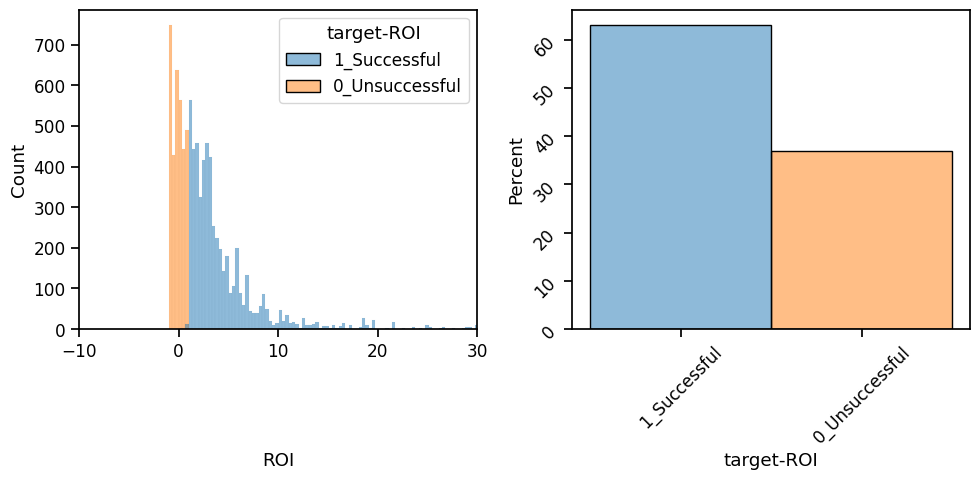

In [13]:
# ax = sns.histplot(data=df, x=target_col, hue)


fig, (ax1,ax2) =  plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data=df, x='ROI', hue='target-ROI', ax=ax1)#, kde=True)
sns.histplot(data=df, x='target-ROI', hue='target-ROI', ax=ax2, legend=False, stat='percent')
# Zoom in on hisgtogram
ax1.set_xlim(left=-10, right=30)
ax2.tick_params(labelrotation=45)
fig.align_xlabels()
fig.tight_layout()


In [14]:
# # Function to categorize movies
# def categorize_movie_success(roi):
#     if roi < 1:
#         return '1_Unsuccessful'
#     elif roi < 3:
#         return '2_Successful'
#     else:
#         return '3_Blockbuster'

# df['target-ROI'] = df['ROI'].map(categorize_movie_success)
# df['target-ROI'].value_counts(dropna=False, normalize=True)

In [15]:
df[target_col].value_counts(dropna=False, normalize=True)

1_Successful      0.630634
0_Unsuccessful    0.369366
Name: target-ROI, dtype: float64

In [16]:
sorted(df[target_col].unique())

['0_Unsuccessful', '1_Successful']

In [17]:
# # ## Combining Target Groups
# # target_map = {'0_Flop':"Low (ROI<1)", 
# #               '1_Moderate Success':"", '2_Success', '3_Blockbuster'

# # Function to categorize movies
# def categorize_movie_binary(roi):
#     if roi < 0:
#         return '0_Flop'
#     elif roi < 1:
#         return '1_Moderate Success'
#     elif roi < 3:
#         return '2_Success'
#     else:
#         return '3_Blockbuster'

# df['target-ROI'] = df['ROI'].map(categorize_movie)
# df['target-ROI'].value_counts(dropna=False, normalize=True)


In [18]:
# Creating df-ml by selecting final target (dropna or filter out group)
df_ml = df.dropna(subset=[target_col])
# df_ml = df.loc[ df[target_col]!="Mid"]
df_ml = df_ml.set_index('review_id')
print(df_ml[target_col].value_counts(dropna=False, normalize=True))
df_ml.head(2)

1_Successful      0.630634
0_Unsuccessful    0.369366
Name: target-ROI, dtype: float64


,imdb_id,movie_id,budget,revenue,original_title,original_language,overview,tagline,certification,rating,review_text,created_at,review_text_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,profit,target-profit,ROI,target-ROI,target-rating
review_id,,,,,,,,,,,,,,,,,,,,,,,,
64a3999fe9da6900c763aa8d,tt2096672,100042,40000000,169837010,Dumb and Dumber To,en,"20 years since their first adventure, Lloyd and Harry go on a road trip to find Harry's newly discovered daughter, who was given up for adoption.",The average person uses 10% of their brain capacity. Imagine what he could do with 1%.,PG-13,7.0,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,2023-07-04 04:01:35.517,Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.,"[better, then, the, original, i, think, was, pretty, funny, i, thought, the, comedy, was, better, then, the, original, too]","[better, original, think, pretty, funny, thought, comedy, better, original]","[well, original, think, pretty, funny, think, comedy, well, original]",better then the original i think was pretty funny i thought the comedy was better then the original too,better original think pretty funny thought comedy better original,well original think pretty funny think comedy well original,129837010,True,3.245925,1_Successful,Mid
643d44864d67910469d853a2,tt0429573,10008,14000000,29612137,An American Haunting,en,Based on the true events of the only case in US History where a spirit caused the death of a man.,Possession Knows No Bounds,None,5.0,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,2023-04-17 13:07:18.832,Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.,"[kind, of, boring, it, 's, a, good, plot, and, storyline, nothing, really, to, keep, you, interested]","[kind, boring, good, plot, storyline, interested]","[kind, boring, good, plot, storyline, interested]",kind of boring it 's a good plot and storyline nothing really to keep you interested,kind boring good plot storyline interested,kind boring good plot storyline interested,15612137,True,1.115153,1_Successful,Mid


In [19]:
df_ml[target_col].value_counts(1)

1_Successful      0.630634
0_Unsuccessful    0.369366
Name: target-ROI, dtype: float64

In [20]:
X = df_ml[text_col]
y = df_ml[target_col]
X.head()

review_id
64a3999fe9da6900c763aa8d                                                                                                                                                   Better then the original I think. Was pretty funny. I thought the comedy was better then the original too.
643d44864d67910469d853a2                                                                                                                                                                       Kind of boring. It's a good plot and storyline. Nothing really to keep you interested.
5f22bd2b43999b00355b26a6    Heartwarming, if not as impactful as it intends to be.\r\n\r\n'Brother Bear' leaves heartfelt feelings and features a cute story. It does get a bit too melancholic in moments where it doesn't need to be or where it's not set up perfectly. It can ...
6592736214956560f7da631f    "Kenai" is a young Inuit warrior who disturbs the spirits when he kills a bear. His punishment is to be turned into one himself,

In [21]:
# Disable parser and ner
# nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])

In [23]:
## Train test split
X_train_full, X_test, y_train_names_full, y_test_names = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)
X_train_full.head()

review_id
58d808c59251411f8905c59f    **But it was all about the sub-operation 'X-Ray'.**\r\n\r\nBringing the stars from other film industry is not we never heard of. It is mainly done for the international appeal. So now it was Liam Neeson's turn to foray into a Korean film. He did ...
612b00d5e04aca0043e2a4a1                                    This movie has a weak understanding of not only the truth in the relationship between the two characters based on actual people, but simplifies the subject of race relations. It was a terrible choice for best picture.
6116ecdecee481002e284eea    I was pleasantly surprised by this one, I had not watched any trailers in the run up to watching it but I was expecting it to be a bit lame but it turned out to be a good movie. I was surprised when pretty much the whole first team was killed off...
57d49dfd92514136fa001890    The woefully generic **When the Bough Breaks** has the gloss factor going for it to a certain extent. Truthfully, its presentabl

### Label Encoding

In [27]:
from sklearn.preprocessing import LabelEncoder

# Instansiate label encoder
encoder = LabelEncoder()

# Fit and transform the training target
y_train_full = pd.Series(encoder.fit_transform(y_train_names_full), 
                    index=y_train_names_full.index, 
                    name=y_train_names_full.name)

# Fit and tranform the test target
y_test = pd.Series(encoder.transform(y_test_names), index=y_test_names.index, 
                    name=y_test_names.name)

y_train_names_full[:10]

review_id
58d808c59251411f8905c59f      1_Successful
612b00d5e04aca0043e2a4a1      1_Successful
6116ecdecee481002e284eea    0_Unsuccessful
57d49dfd92514136fa001890      1_Successful
5f8ca97a89f7490037ff2a08      1_Successful
631fa2995684630083cd4c4e      1_Successful
5f3eaa00028f14003356044e    0_Unsuccessful
6078cbe21b1f3c0040d2b8c2      1_Successful
54559acec3a3683e23000c26    0_Unsuccessful
63bb9733a6e2d20092107cc2      1_Successful
Name: target-ROI, dtype: object

### Addressing Class Balance

In [28]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),
                                        y_train_full)
X_train.shape

(4904, 1)

In [29]:
# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()
X_train.shape

(4904,)

In [30]:
y_train.value_counts()

0    2452
1    2452
Name: target-ROI, dtype: int64

## Modeling

In [31]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))
vectorizer.fit(X_train)

CountVectorizer()

In [32]:
# Saves vocab - matches number of columns above
vocab_dict = vectorizer.vocabulary_
len(vocab_dict)

40583

In [33]:
# Words are now the feature_names
feature_names = vectorizer.get_feature_names_out()
len(feature_names)

40583

In [34]:
# FPATHS

### DummyClassifier

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2452
           1       0.51      0.51      0.51      2452

    accuracy                           0.51      4904
   macro avg       0.51      0.51      0.51      4904
weighted avg       0.51      0.51      0.51      4904



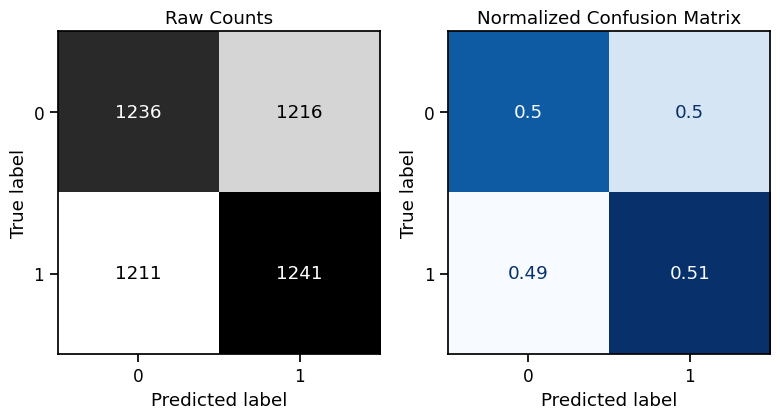


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.39      0.49      0.43       859
           1       0.62      0.51      0.56      1382

    accuracy                           0.50      2241
   macro avg       0.50      0.50      0.50      2241
weighted avg       0.53      0.50      0.51      2241



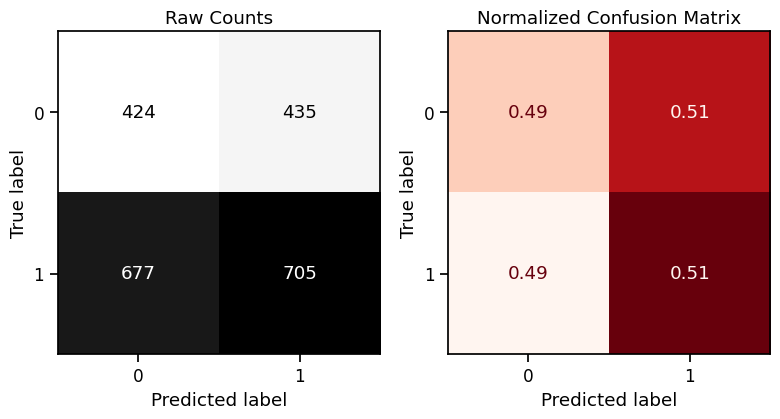

In [35]:
from sklearn.dummy import DummyClassifier
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',DummyClassifier(strategy='stratified'))
])

## Fit an evaluate a Logistic Regression
clf_pipe.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test,figsize=(8,12),values_format=".2g")
# joblib.dump(clf_pipe, FPATHS['models']['ml']['logreg'])

### Bayes

In [36]:
 FPATHS['models']['ml']#['bayes']

{'bayes_joblib': 'Models/bayes-clf.joblib',
 'random_forest_joblib': 'Models/random-forest.joblib',
 'logreg_joblib': 'Models/log-reg.joblib'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2452
           1       0.99      0.99      0.99      2452

    accuracy                           0.99      4904
   macro avg       0.99      0.99      0.99      4904
weighted avg       0.99      0.99      0.99      4904



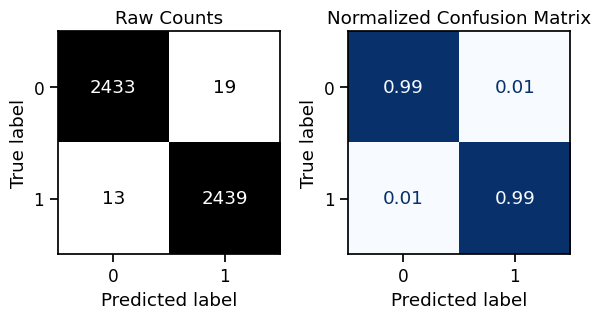


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.79      0.63       859
           1       0.81      0.57      0.67      1382

    accuracy                           0.65      2241
   macro avg       0.67      0.68      0.65      2241
weighted avg       0.70      0.65      0.65      2241



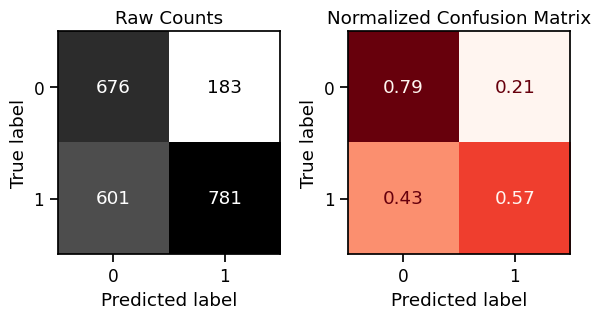

['Models/bayes-clf.joblib']

In [37]:
vectorizer = CountVectorizer(stop_words='english',
    ngram_range=(1,2)
                            )

clf_bayes = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',MultinomialNB())
])

## Fit an evaluate a Bayesian Model
clf_bayes.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_bayes, X_train,y_train, X_test, y_test)
joblib.dump(clf_bayes, FPATHS['models']['ml']['bayes_joblib'])

### LogisticRegression

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2452

    accuracy                           1.00      4904
   macro avg       1.00      1.00      1.00      4904
weighted avg       1.00      1.00      1.00      4904



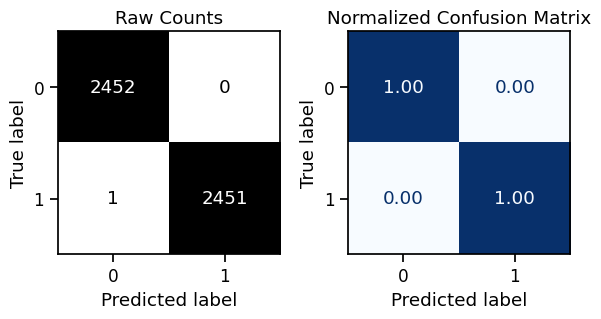


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.63      0.56       859
           1       0.73      0.61      0.66      1382

    accuracy                           0.62      2241
   macro avg       0.62      0.62      0.61      2241
weighted avg       0.64      0.62      0.62      2241



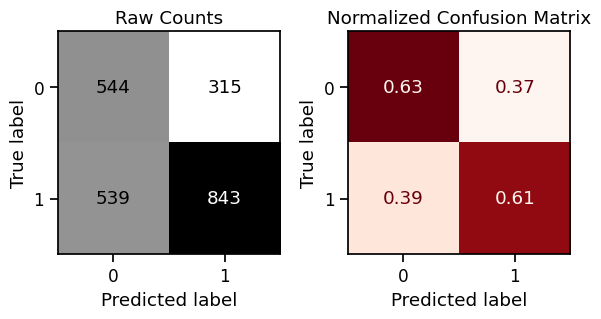

['Models/log-reg.joblib']

In [38]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(max_iter=500,C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg_joblib'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2452

    accuracy                           1.00      4904
   macro avg       1.00      1.00      1.00      4904
weighted avg       1.00      1.00      1.00      4904



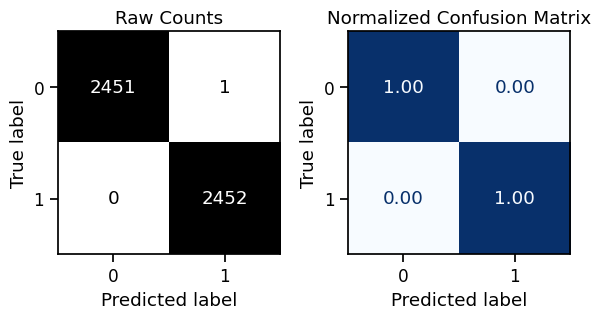


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       859
           1       0.75      0.64      0.69      1382

    accuracy                           0.64      2241
   macro avg       0.64      0.65      0.64      2241
weighted avg       0.67      0.64      0.65      2241



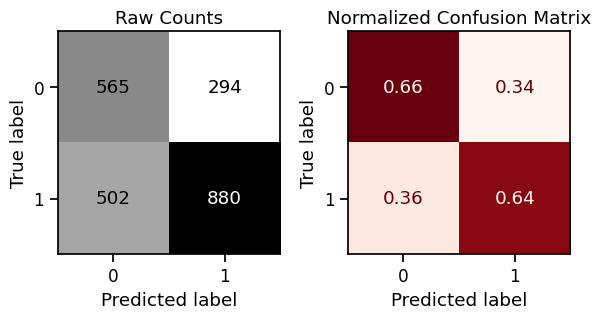

['Models/log-reg.joblib']

In [39]:
# Logreg-tfidf

vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,2))

clf_logreg = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LogisticRegression(max_iter=500,C=1e12))
])

## Fit an evaluate a Logistic Regression
clf_logreg.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg_joblib'])

In [40]:
## TEMP COMMENTED OUT
# # LogregCV-tfidf 

# vectorizer = TfidfVectorizer(stop_words=None,
#     ngram_range=(1,2))

# clf_logreg = Pipeline([
#     ('vectorizer',vectorizer),
#     ('clf',LogisticRegressionCV(max_iter=200))
# ])

# ## Fit an evaluate a Logistic Regression
# clf_logreg.fit(X_train, y_train)
# ds.evaluate.evaluate_classification(clf_logreg, X_train,y_train, X_test, y_test)
# joblib.dump(clf_logreg, FPATHS['models']['ml']['logreg'])

In [41]:
# ## Fit an evaluate a Naive Bayes Classifier
# clf_bayes.fit(X_train, y_train)
# ds.evaluate.evaluate_classification(clf_bayes, X_train,y_train, X_test, y_test)
# joblib.dump(clf_bayes, FPATHS['models']['ml']['bayes'])

### RandomForest

In [42]:
# FPATHS['models']['ml']['random_forest']

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2452

    accuracy                           1.00      4904
   macro avg       1.00      1.00      1.00      4904
weighted avg       1.00      1.00      1.00      4904



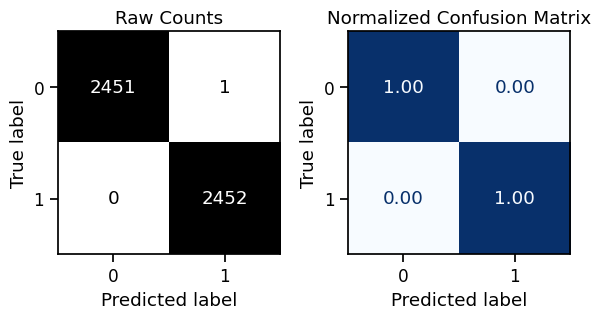


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.67      0.55       859
           1       0.71      0.51      0.60      1382

    accuracy                           0.57      2241
   macro avg       0.59      0.59      0.57      2241
weighted avg       0.62      0.57      0.58      2241



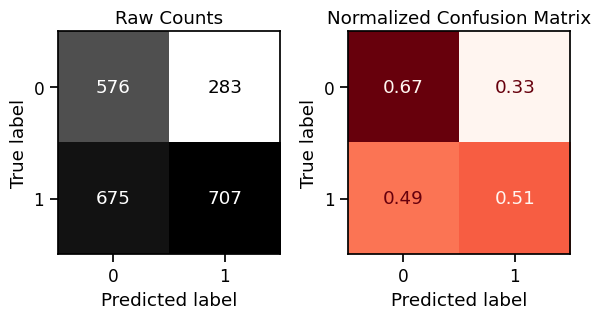

In [43]:
vectorizer = CountVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
# joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest_joblib'])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2452

    accuracy                           1.00      4904
   macro avg       1.00      1.00      1.00      4904
weighted avg       1.00      1.00      1.00      4904



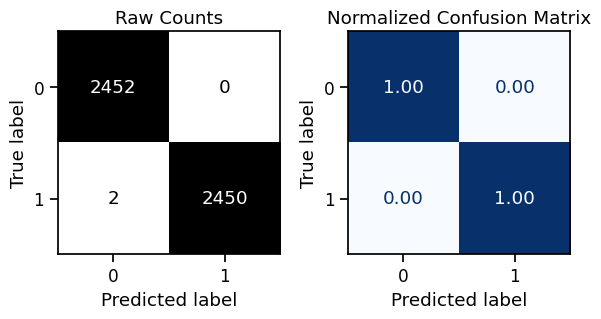


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.64      0.55       859
           1       0.72      0.56      0.63      1382

    accuracy                           0.59      2241
   macro avg       0.60      0.60      0.59      2241
weighted avg       0.62      0.59      0.60      2241



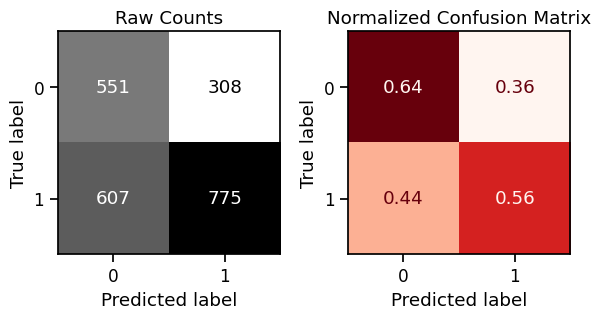

In [44]:
vectorizer = TfidfVectorizer(stop_words='english',
    ngram_range=(1,2))

clf_rf = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_rf.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_rf, X_train,y_train, X_test, y_test)
# joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest_joblib'])

### SVC

In [45]:
encoder.classes_

array(['0_Unsuccessful', '1_Successful'], dtype=object)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2452
           1       0.99      0.99      0.99      2452

    accuracy                           0.99      4904
   macro avg       0.99      0.99      0.99      4904
weighted avg       0.99      0.99      0.99      4904



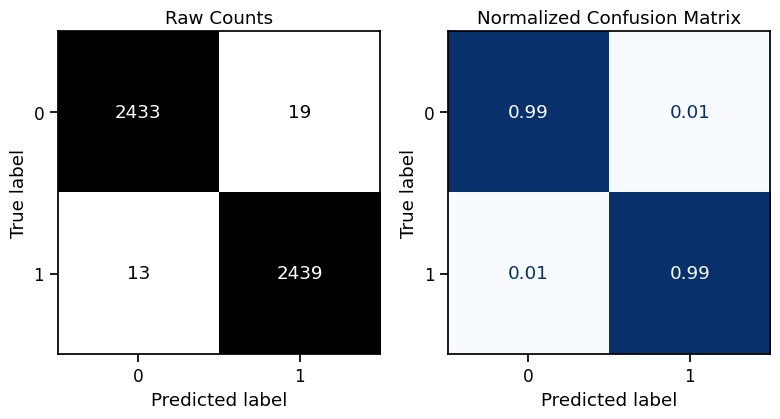


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.68      0.60       859
           1       0.76      0.63      0.69      1382

    accuracy                           0.65      2241
   macro avg       0.65      0.65      0.64      2241
weighted avg       0.67      0.65      0.65      2241



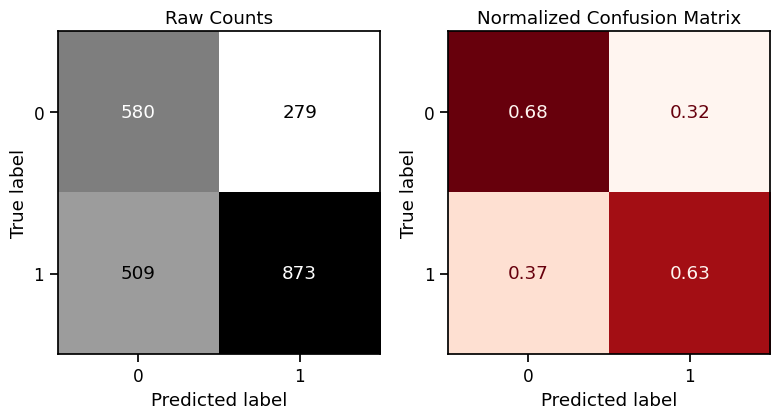

In [46]:
from sklearn.svm import SVC, LinearSVC

vectorizer = TfidfVectorizer(stop_words=None,
    ngram_range=(1,1))

clf_pipe = Pipeline([
    ('vectorizer',vectorizer),
    ('clf',LinearSVC(class_weight='balanced'))
])

## Fit an evaluate a Logistic Regression
clf_pipe.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test,
                                    # target_names=encoder.classes_,
                                    figsize=(8,10))
# joblib.dump(clf_rf, FPATHS['models']['ml']['random_forest'])

## GridSearching ML Models/Prep

In [47]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [ 0.9,1],
    'vectorizer__min_df': [ 1,2, 3], 
    # "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    'vectorizer__ngram_range':[(1,1),(1,2)],

}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    # "vectorizer__use_idf": [True, False],
    "vectorizer__smooth_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_vectorizters_combined = [param_grid_count, param_grid_tfidf]
params_vectorizters_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.9, 1],
  'vectorizer__min_df': [1, 2, 3],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__smooth_idf': [True, False],
  'vectorizer__max_df': [0.9, 1],
  'vectorizer__min_df': [1, 2, 3],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]}]

### RandomForest

<Axes: ylabel='Count'>

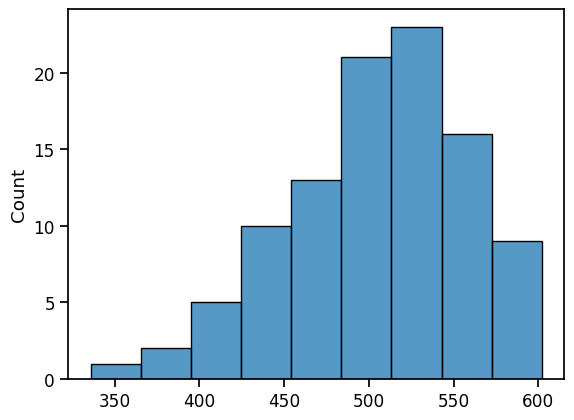

In [48]:
sns.histplot([t.get_depth() for t in clf_rf[-1].estimators_])

In [49]:
import copy

In [50]:
params_rf = {'clf__max_depth':[None, 500, 600],
            "clf__min_samples_leaf":[1,2],
            "clf__criterion":['gini','entropy']}

## Add rf params to each dict in params_vectorizters_combined list 
params_grid_rf_final = copy.deepcopy(params_vectorizters_combined)#.copy()
for params in params_grid_rf_final:
    params.update(params_rf)

In [51]:
params_grid_rf_final

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.9, 1],
  'vectorizer__min_df': [1, 2, 3],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)],
  'clf__max_depth': [None, 500, 600],
  'clf__min_samples_leaf': [1, 2],
  'clf__criterion': ['gini', 'entropy']},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__smooth_idf': [True, False],
  'vectorizer__max_df': [0.9, 1],
  'vectorizer__min_df': [1, 2, 3],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)],
  'clf__max_depth': [None, 500, 600],
  'clf__min_samples_leaf': [1, 2],
  'clf__criterion': ['gini', 'entropy']}]

In [52]:
# %%time

# # Create pipeline
# # model = make_pipeline(TfidfVectorizer(), RandomForestClassifier(random_state=42))
# gs_pipe_rf = Pipeline([('vectorizer',CountVectorizer()), 
#                 ('clf',RandomForestClassifier(random_state=42))
#                       ])#

# # Create gridsearch
# grid_search_rf = GridSearchCV(gs_pipe_rf, params_grid_rf_final, 
#                               scoring='recall_macro',
#                               cv=3, verbose=1, n_jobs=-1)

# # Fit the model
# grid_search_rf.fit(X_train, y_train)

# # Clearning gs. verbose messages
# clear_output()

# # Get the best parameters and score
# best_params = grid_search_rf.best_params_
# best_score = grid_search_rf.best_score_

# best_params, best_score

In [53]:
# # Now define the best version of the model
# best_model = grid_search_rf.best_estimator_

# # Predict and Evaluate with the custom function
# ds.evaluate_classification(best_model, X_train, y_train, X_test, y_test)


### LogisticRegression

In [54]:
# Params compatible with penality='elasticnet'

elasticnet_params = {'clf__solver' : ['saga'],
               'clf__penalty' : ['elasticnet'],
                'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4,
                                                 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
# # Params compatible with penality='l2'
# l2_params = {'clf__solver': ['lbfgs', 'liblinear', 'newton-cg',
#                                             'newton-cholesky', 'sag', 'saga'],
#                   'clf__penalty' : ['l2'],
#                   'clf__C': [0.0001, 0.001, 0.01, 0.1,
#                                             1, 10, 100, 1000] }
# # Params compatible with penality='l1'
# l1_params = {'clf__solver' : ['liblinear', 'saga'],
#                'clf__penalty' : ['l1'],
#                 'clf__C': [0.0001, 0.001, 0.01, 0.1, 1,
#                                           10, 100, 1000]}
# # Params with no penality
# none_params = {'clf__solver' : ['lbfgs', 'newton-cg',
#                                                'newton-cholesky', 'sag', 'saga'],
#                'clf__penalty' : [None]}

#####
# Now make a list of the param dictionaries
logreg_param_grids = [
    # l2_params, l1_params,
    elasticnet_params, 
    # none_params
]
logreg_param_grids

[{'clf__solver': ['saga'],
  'clf__penalty': ['elasticnet'],
  'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}]

In [55]:
params_vectorizters_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.9, 1],
  'vectorizer__min_df': [1, 2, 3],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__smooth_idf': [True, False],
  'vectorizer__max_df': [0.9, 1],
  'vectorizer__min_df': [1, 2, 3],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]}]

In [56]:
import itertools

paired_param_grids = list(itertools.product(params_vectorizters_combined, logreg_param_grids))
paired_param_grids[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.9, 1],
  'vectorizer__min_df': [1, 2, 3],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]},
 {'clf__solver': ['saga'],
  'clf__penalty': ['elasticnet'],
  'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]})

In [57]:
# Loop through the product list of paired dictionaries to combine
final_params = []
for (vector_params, model_params) in  paired_param_grids:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
len(final_params)

2

In [58]:
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.9, 1],
 'vectorizer__min_df': [1, 2, 3],
 'vectorizer__stop_words': [None, 'english'],
 'vectorizer__ngram_range': [(1, 1), (1, 2)],
 'clf__solver': ['saga'],
 'clf__penalty': ['elasticnet'],
 'clf__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

In [59]:
# Determine # of cpus
import os
n_cpus = os.cpu_count()
n_cpus

10

In [60]:
# %%time
# logreg_pipe = Pipeline([
#     ('vectorizer',TfidfVectorizer()),
#     ('clf',LogisticRegression(max_iter=500))
# ])
# # Create grid search
# grid_search = GridSearchCV(logreg_pipe, final_params, scoring='recall_macro',cv=3, verbose=1, n_jobs= n_cpus-2)
    
    
# # Fit the model
# grid_search.fit(X_train, y_train)


In [61]:
# grid_search.best_params_

In [62]:
# # Now define the best version of the model
# best_model = grid_search.best_estimator_

# # Predict and Evaluate with the custom function
# ds.evaluate_classification(best_model, X_train, y_train, X_test, y_test)


## 🚧Previous

In [63]:
# raise Exception("must update code below")

## GS from LP

In [64]:
# %%time
## TEMP: COMPARE TIMING IF n_jobs is NOT -1
# # Create grid search
# grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'accuracy', verbose=1)#, n_jobs=-1)
    
    
# # Fit the model
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [65]:
%%time
SKIP = True

if not SKIP:
    # Create grid search
    grid_search = GridSearchCV(vect_pipe, final_params, cv=3, scoring = 'recall_macro', verbose=2, n_jobs=-1)
        
        
    # Fit the model
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


In [66]:
if not SKIP:
    
    # Now define the best version of the model
    best_model = grid_search.best_estimator_
    
    # Predict and Evaluate with the custom function
    ds.evaluate.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### Saving ML Model & Data

In [67]:

# Save training data
fpath_train_joblib = FPATHS['data']['ml-nlp']['train_joblib']
joblib.dump([X_train, y_train],fpath_train_joblib)

# Save test data
fpath_test_joblib = FPATHS['data']['ml-nlp']['test_joblib']
joblib.dump([X_test, y_test],fpath_test_joblib)

# if not SKIP:
#     # Saving the best model 
#     fpath_best_ml_model  = "Models/best-ml-model.joblib"
#     joblib.dump(best_model, fpath_best_ml_model)

['Data-NLP/modeling/testing-data.joblib']

### Ngrams

In [68]:
# #our pre-exting ngram df function https://login.codingdojo.com/m/692/16501/124388

# import pandas as pd
# def get_ngram_measures_finder(tokens, ngrams=2, get_scores_df=False, measure='raw_freq', top_n=None, min_freq = 1,
#                              words_colname='Words'):
#     import nltk
#     if ngrams == 4:
#         MeasuresClass = nltk.collocations.QuadgramAssocMeasures
#         FinderClass = nltk.collocations.QuadgramCollocationFinder
        
#     elif ngrams == 3: 
#         MeasuresClass = nltk.collocations.TrigramAssocMeasures
#         FinderClass = nltk.collocations.TrigramCollocationFinder
#     else:
#         MeasuresClass = nltk.collocations.BigramAssocMeasures
#         FinderClass = nltk.collocations.BigramCollocationFinder

#     measures = MeasuresClass()
    
   
#     finder = FinderClass.from_words(tokens)
#     finder.apply_freq_filter(min_freq)
#     if measure=='pmi':
#         scored_ngrams = finder.score_ngrams(measures.pmi)
#     else:
#         measure='raw_freq'
#         scored_ngrams = finder.score_ngrams(measures.raw_freq)

#     df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
#     if top_n is not None:
#         return df_ngrams.head(top_n)
#     else:
#         return df_ngrams

### Text Explainer

In [69]:
X_to_pred = 'It was the best move i had ever seen until the last 30 mins, which ruined the whole thing.'

In [70]:
y

review_id
64a3999fe9da6900c763aa8d      1_Successful
643d44864d67910469d853a2      1_Successful
5f22bd2b43999b00355b26a6    0_Unsuccessful
6592736214956560f7da631f    0_Unsuccessful
628159c8caa50850dcf93d33    0_Unsuccessful
                                 ...      
5e20dedc397df000129666b8      1_Successful
5ef819bba284eb00398dc810      1_Successful
600616349a358d0040c2ecad      1_Successful
5a6940bc9251414a2e009179    0_Unsuccessful
6449359c2fdec602fca107cb    0_Unsuccessful
Name: target-ROI, Length: 8964, dtype: object

In [71]:
clf_bayes.predict([X_to_pred])

array([1])

In [72]:
y.unique()

array(['1_Successful', '0_Unsuccessful'], dtype=object)

In [73]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=y.unique())
explanation = explainer.explain_instance(X_to_pred, clf_bayes.predict_proba)
explanation.show_in_notebook()

# Neural Networks

Since we already have train/test X and y vars, we will make 2 dataset objects using tf.data.Dataset.from_tensor_slices.

1. The training dataset using X_train, y_train (that we resampled/balanced)
2. The val/test dataset using X_test, y-test.

We will then split the val/test dataset into a val/test split.


In [74]:
# Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Shuffle dataset once
train_ds = train_ds.shuffle(buffer_size=len(train_ds), seed=321,
                            reshuffle_each_iteration=False)

In [75]:
# Convert test to dataset object and split
val_test_split_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_test_split_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [76]:
# Calculate # of samples for 50/50 val/test split
n_val_samples =  int(len(val_test_split_ds) * .5)
n_val_samples

1120

In [77]:
## Perform the val/test split
## Create the validation dataset
val_ds = val_test_split_ds.take(n_val_samples)

## Create the test dataset
test_ds = val_test_split_ds.skip(n_val_samples)
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(4904, 1120, 1121)

In [78]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds), seed=321)


#  Setting the batch_size for all datasets
BATCH_SIZE = 32

# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 154 training batches.
 There are 35 validation batches.
 There are 36 testing batches.


In [79]:
# # taking a sample 
# example_X, example_y= train_ds.take(1).get_single_element()
# print(example_X)
# print(example_y)

In [80]:
## Saving Train and test dataset
fname_train_ds = FPATHS['data']['nn']['train_dir']
train_ds.save(path=fname_train_ds,)

fname_test_ds = FPATHS['data']['nn']['test_dir']
test_ds.save(path=fname_test_ds,)

2024-01-29 18:34:56.179212: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


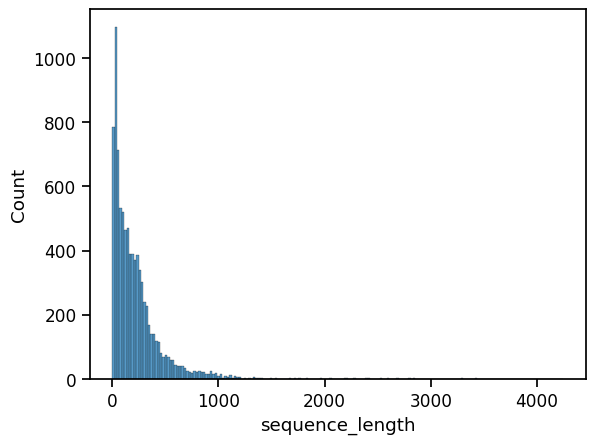

In [81]:
# df_ml = df_ml.copy()
df_ml['sequence_length'] = df_ml['review_text'].map( lambda x: len(x.split(" ")))
ax = sns.histplot(df_ml['sequence_length'])

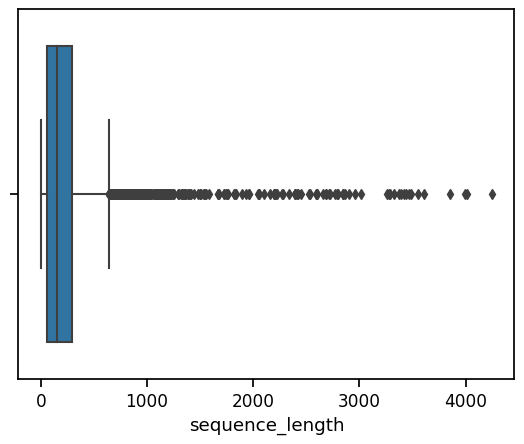

In [82]:
ax = sns.boxplot(data=df_ml, x='sequence_length')

In [153]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
# ds_texts.take(1).get_single_element()

In [154]:
SEQUENCE_LENGTH = 300
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
    # max_tokens=50_000
)
sequence_vectorizer.adapt(ds_texts)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE


48459

#### LSTM

In [155]:
# # Code below is from CNN Week
# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, verbose=True)
#     return [early_stop]


### Call backs
# @tf.function
def get_callbacks(monitor='val_accuracy',patience=3, restore_best_weights=False,
                  start_from_epoch=0,baseline_value=None,
                  verbose_early_stopping=1,  
                  tensborboard=False, logdir="/tmp/tb_logs",
                 tb_embed_freq=0, tb_write_images = False, tb_hist_freq = 0):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, #mode=mode, 
                                                      restore_best_weights=restore_best_weights,
                                                      baseline=baseline_value,
                                                      start_from_epoch=start_from_epoch,
                                                      verbose=verbose_early_stopping)

    if tensborboard:
        tboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=tb_hist_freq,write_images=tb_write_images,
                                                embeddings_freq=tb_embed_freq,)
        return [ early_stopping, tboard]
    else:
        return [early_stopping]

In [156]:
# Define a function for building an LSTM model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.models import Sequential


# @tf.function
def build_lstm_model(text_vectorization_layer, binary_task=True):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()

    if binary_task == True:
        final_activation = "sigmoid"  # ?
        loss_func = "binary_crossentropy"
        nunits_output = 1
    else:
        final_activation = "softmax"  # ?
        loss_func = "sparse_categorical_crossentropy"
        nunits_output = len(classes)

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential(
        [
            text_vectorization_layer,
            layers.Embedding(
                input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
            ),
        ]
    )

    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(64, recurrent_dropout=0.1, return_sequences=True))
    lstm_model.add(layers.Dropout(0.5))
    lstm_model.add(layers.LSTM(64, return_sequences=True))
    lstm_model.add(layers.GlobalMaxPooling1D())

    # Add output layer
    lstm_model.add(layers.Dense(nunits_output, activation=final_activation))

    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    lstm_model.compile(
        optimizer=optimizer,  #'adam',
        loss=loss_func,  # "sparse_categorical_crossentropy",
        metrics=[  # tf.metrics.Accuracy(name='accuracy'),
            "accuracy",
            tf.metrics.Recall(name="recall")
            # tf.keras.metrics.Recall(class_id=0, name="recall_class_0"),
            # tf.keras.metrics.Recall(class_id=1, name="recall_class_1"),
        ],
    )

    lstm_model.summary()
    return lstm_model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_16 (Embedding)    (None, 300, 50)           2422950   
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           29440     
                                                                 
 dropout_1 (Dropout)         (None, 300, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 64)           33024     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                    

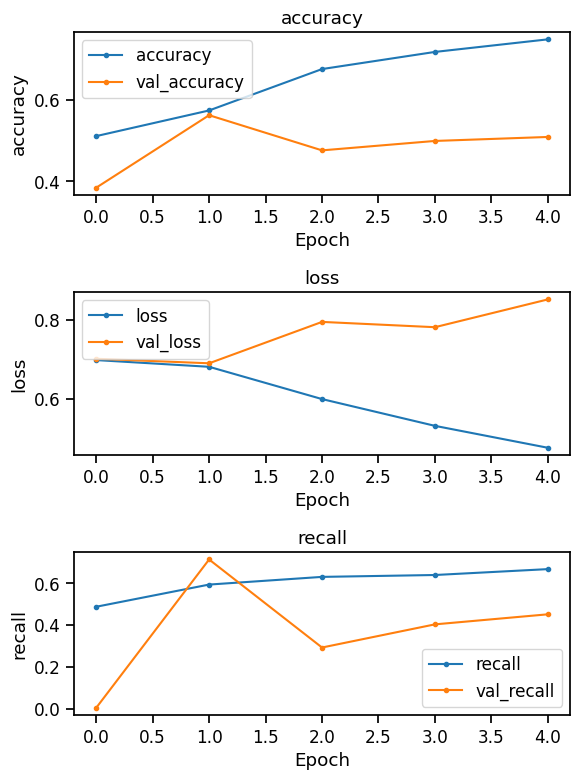

In [157]:
EMBED_DIM = 50
classes = y_train.unique()
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

ds.evaluate.plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.83      0.80      2452
           1       0.82      0.74      0.78      2452

    accuracy                           0.79      4904
   macro avg       0.79      0.79      0.79      4904
weighted avg       0.79      0.79      0.79      4904



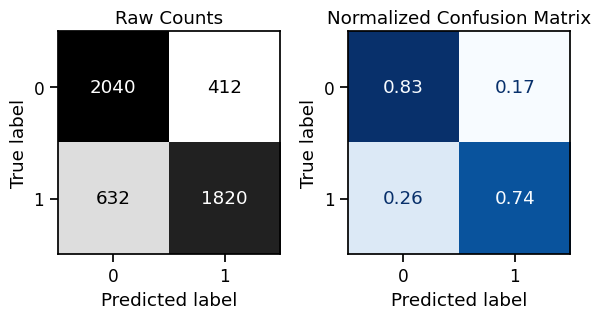


- Evaluating Training Data:
154/154 [==============================] - 7s 44ms/step - loss: 0.4038 - accuracy: 0.7871 - recall: 0.7423
{'loss': 0.4037749767303467, 'accuracy': 0.7871125340461731, 'recall': 0.7422512173652649}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.42      0.60      0.50       426
           1       0.67      0.50      0.58       695

    accuracy                           0.54      1121
   macro avg       0.55      0.55      0.54      1121
weighted avg       0.58      0.54      0.55      1121



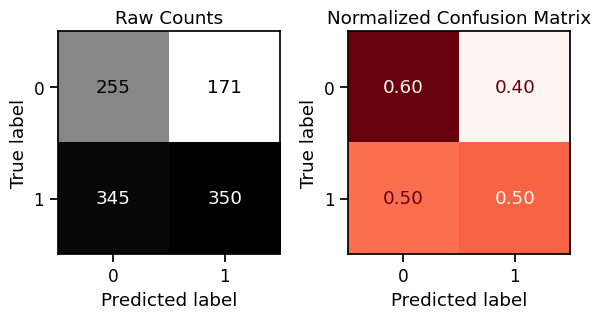


- Evaluating Test Data:
36/36 [==============================] - 2s 42ms/step - loss: 0.8573 - accuracy: 0.5397 - recall: 0.5036
{'loss': 0.857337474822998, 'accuracy': 0.5396966934204102, 'recall': 0.5035971403121948}


In [158]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [159]:
# raise Exception("Add model fpaths to filepaths.json first and then use those below:")

#### Saving Model 1

In [160]:
FPATHS['models']

{'ml': {'bayes_joblib': 'Models/bayes-clf.joblib',
  'random_forest_joblib': 'Models/random-forest.joblib',
  'logreg_joblib': 'Models/log-reg.joblib'},
 'nn': {'LSTM_dir': 'Models/keras/lstm/',
  'GRU_dir': 'Models/keras/gru/',
  'Attention_model_dir': 'Models/keras/attn/'}}

In [161]:
# Saving model in tf format 
fname_model_lstm = FPATHS['models']['nn']['LSTM_dir']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
lstm_model.save(fname_model_lstm, save_format='tf')

INFO:tensorflow:Assets written to: Models/keras/lstm/assets


INFO:tensorflow:Assets written to: Models/keras/lstm/assets


In [162]:
## Loading the Model
loaded_network = tf.keras.models.load_model(fname_model_lstm)
loaded_network.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_16 (Embedding)    (None, 300, 50)           2422950   
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           29440     
                                                                 
 dropout_1 (Dropout)         (None, 300, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 300, 64)           33024     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                    

In [163]:
# # Obtain the results
# results = ds.evaluate.evaluate_classification_network(
#     loaded_network, X_train=train_ds, 
#     X_test=test_ds, history=history
# );

## Testing Saving/Loading Dataset Objects

### RNN Model 2

In [164]:
def build_gru_model_bi_pool(text_vectorization_layer, binary_task=True):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    
    if binary_task == True:
        final_activation = "sigmoid"  # ?
        loss_func = "binary_crossentropy"
        nunits_output = 1
    else:
        final_activation = "softmax"  # ?
        loss_func = "sparse_categorical_crossentropy"
        nunits_output = len(classes)
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential(
        [
            text_vectorization_layer,
            layers.Embedding(
                input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH
            ),
        ]
    )
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    model.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    model.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    model.add(layers.Dense(nunits_output, activation=final_activation))
                     
    # optimizer = optimizers.legacy.Adam()
    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, 
                  loss=loss_func,
                              metrics=[  # tf.metrics.Accuracy(name='accuracy'),
            "accuracy",
            tf.metrics.Recall(name="recall")
                              ])
    model.summary()
    return model

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_18 (Embedding)    (None, 300, 50)           2422950   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 256)         138240    
 nal)                                                            
                                                                 
 global_max_pooling1d_4 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 1)                 257       
                                                     

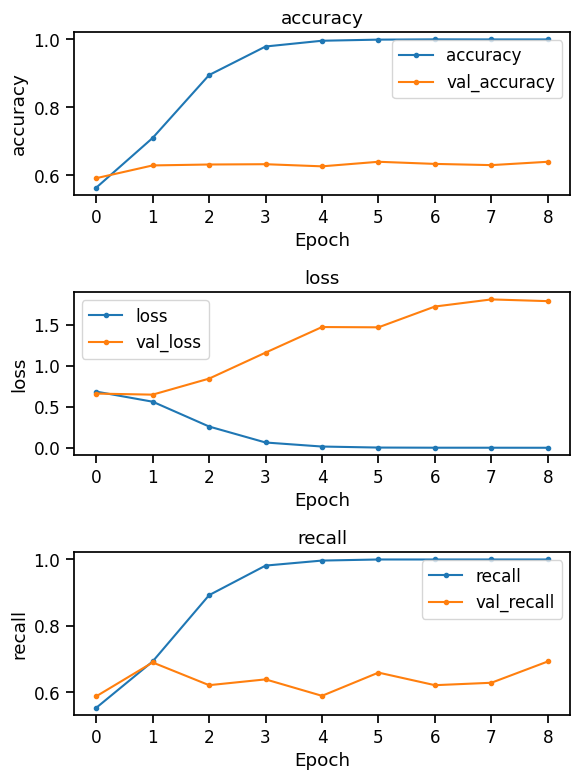

In [165]:
# EMBED_DIM = 50
# classes = y_train.unique()
# MAX_TOKENS = sequence_vectorizer.vocabulary_size()
# Build the lstm model and specify the vectorizer
bidirection_model = build_gru_model_bi_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = bidirection_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
ds.evaluate.plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2452
           1       1.00      1.00      1.00      2452

    accuracy                           1.00      4904
   macro avg       1.00      1.00      1.00      4904
weighted avg       1.00      1.00      1.00      4904



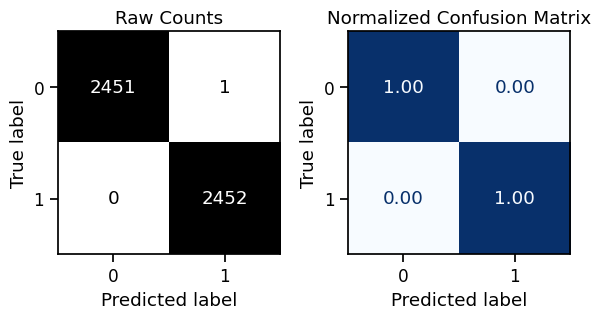


- Evaluating Training Data:
154/154 [==============================] - 6s 41ms/step - loss: 7.9339e-04 - accuracy: 0.9998 - recall: 1.0000
{'loss': 0.000793391780462116, 'accuracy': 0.9997960925102234, 'recall': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.55      0.54       426
           1       0.72      0.71      0.71       695

    accuracy                           0.65      1121
   macro avg       0.63      0.63      0.63      1121
weighted avg       0.65      0.65      0.65      1121



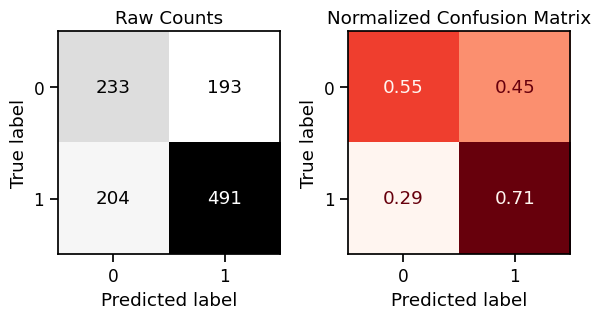


- Evaluating Test Data:
36/36 [==============================] - 1s 40ms/step - loss: 1.6625 - accuracy: 0.6459 - recall: 0.7065
{'loss': 1.662490725517273, 'accuracy': 0.6458519101142883, 'recall': 0.7064748406410217}


In [166]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    bidirection_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

In [167]:
# Saving model in tf format 
fname_model_gru = FPATHS['models']['nn']['GRU_dir']# "Models/keras/lstm/" # Filename is a folder for save_format='tf'
bidirection_model.save(fname_model_gru, save_format='tf')

INFO:tensorflow:Assets written to: Models/keras/gru/assets


INFO:tensorflow:Assets written to: Models/keras/gru/assets


## Attention model

In [168]:
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras import models

def build_attention_model(text_vectorization_layer, binary_task=True):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    
    if binary_task == True:
        final_activation = "sigmoid"  # ?
        loss_func = "binary_crossentropy"
        nunits_output = 1
    else:
        final_activation = "softmax"  # ?
        loss_func = "sparse_categorical_crossentropy"
        nunits_output = len(classes)

    # Input layer
    input_layer = layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.string) 
    flattened_input = tf.reshape(input_layer, (-1,))
    

    # Vectorization and embedding
    x = text_vectorization_layer(flattened_input)
    x = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH)(x)

    # MultiHeadAttention
    # In this case, using the same tensor for query, key, and value
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=200, value_dim=EMBED_DIM)(x, x, x)
    x = layers.Flatten()(attention_output)

    # Further layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(nunits_output, activation=final_activation)(x)

    # Model creation
    model = models.Model(inputs=input_layer, outputs=outputs)

    # optimizer = optimizers.legacy.Adam()
    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  # 0.9)
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, 
                  loss=loss_func,
                              metrics=[  # tf.metrics.Accuracy(name='accuracy'),
            "accuracy",
            tf.metrics.Recall(name="recall")
                              ])
    model.summary()
    return model


In [169]:
SEQUENCE_LENGTH

300

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 tf.reshape_7 (TFOpLambda)      (None,)              0           ['input_13[0][0]']               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 300)         0           ['tf.reshape_7[0][0]']           
 orization)                                                                                       
                                                                                                  
 embedding_19 (Embedding)       (None, 300, 50)      2422950     ['text_vectorization_1[3][0

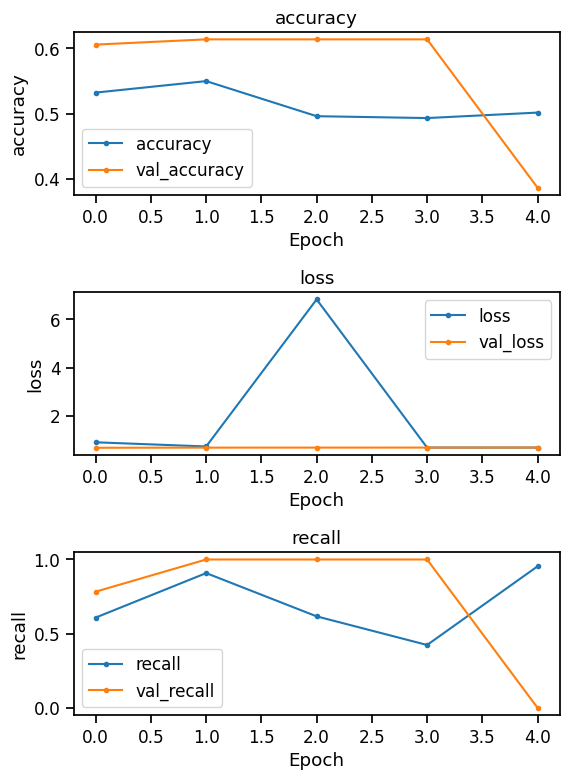

In [170]:
# EMBED_DIM = 50
# classes = y_train.unique()
# MAX_TOKENS = sequence_vectorizer.vocabulary_size()
# Build the lstm model and specify the vectorizer
attention_model = build_attention_model(sequence_vectorizer, binary_task=True)

# Defien number of epocs
EPOCHS = 30

# Fit the model
history = attention_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
ds.evaluate.plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2452
           1       0.00      0.00      0.00      2452

    accuracy                           0.50      4904
   macro avg       0.25      0.50      0.33      4904
weighted avg       0.25      0.50      0.33      4904



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

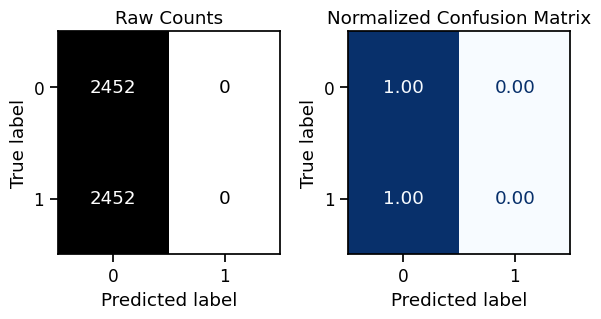

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi


- Evaluating Training Data:
154/154 [==============================] - 10s 66ms/step - loss: 0.6931 - accuracy: 0.5000 - recall: 0.0000e+00
{'loss': 0.6930824518203735, 'accuracy': 0.5, 'recall': 0.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       426
           1       0.00      0.00      0.00       695

    accuracy                           0.38      1121
   macro avg       0.19      0.50      0.28      1121
weighted avg       0.14      0.38      0.21      1121



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

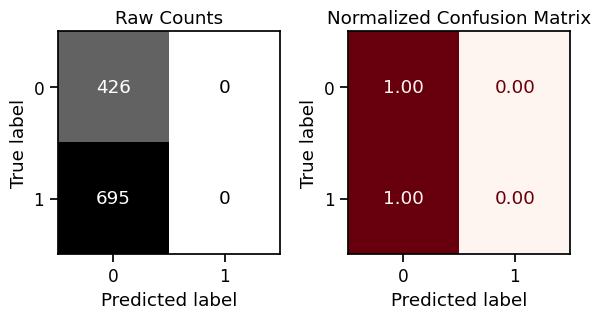


- Evaluating Test Data:
 2/36 [>.............................] - ETA: 2s - loss: 0.6970 - accuracy: 0.3438 - recall: 0.0000e+00

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

36/36 [==============================] - 2s 65ms/step - loss: 0.6961 - accuracy: 0.3800 - recall: 0.0000e+00
{'loss': 0.6961458325386047, 'accuracy': 0.38001784682273865, 'recall': 0.0}


In [171]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    attention_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

### Saving Tensorflow Datasets and Best Model